In [97]:
import os
import re
import sys
import csv
import time
import json
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from scipy import optimize
from scipy.stats import chi2, norm
from scipy.integrate import quad
from scipy.special import erfinv

from sklearn.metrics.pairwise import pairwise_distances

import torch
import falkon

sys.path.insert(0, "../notebooks")
from plot_utils import plot_one_t, plot_two_t


## Parameter testing

In [98]:
def from_path_to_plot(path:str, m=3000, l=1e-7, bin=30):
    with open(path) as f:
        # t_list = np.array([float(row.split()[0]) for row in f])
        t_list = np.array([float(row.split()[0]) for row in f])
        # t_list = np.random.choice(t_list, 100, replace=False)

    print("number of toys:", len(t_list))
    
    dof_fit, _, _ = chi2.fit(t_list, floc=0, fscale=1)
    _, ks_p_value = stats.kstest(t_list, "chi2", args=(dof_fit,))
    print("ks pvalue:", np.around(ks_p_value, 3))
    
    ref_chi2 = chi2(df=dof_fit)
    t_ref_bins  = np.arange(int(np.min(t_list))-50, int(np.max(t_list))+100, bin)
    xgrid_ref   = np.arange(int(np.min(t_list))-100, int(np.max(t_list))+100, 2)
    plot_one_t(
        t_distribution  = t_list,
        t_bins          = t_ref_bins,
        chi2            = ref_chi2,
        chi2_grid       = xgrid_ref,
        show_hist       = True,
        show_error      = False,
        compute_rate    = False,
        err_marker      = "o",
        err_markersize  = 10,
        err_capsize     = 5,
        err_elinewidth  = 4,
        err_capthick    = 4,
        err_color       = "black",
        figsize         = (10, 6),
        fontsize        = 18,
        cms             = False,
        cms_label       = "",
        cms_rlabel      = "",
        hist_ecolor     = ("#494B69", 1.0),
        hist_fcolor     = ("#494B69", 0.1),
        chi2_color      = ("#D8707C", 0.8),
        hist_lw         = 4,
        chi2_lw         = 6,
        hist_type       = "stepfilled",
        hist_label      = "$\it{t}$ distribution",
        chi2_label      = "Target $\chi^2$(dof=%.2f)"%(dof_fit),
        xlabel          = r"$t$",
        ylabel          = "Density",
        show_plot       = True,
        save_plot       = False,
        plot_name       = "t_distribution_"+str(l)+"_"+str(M),
        plot_path       = "",
        plot_format     = "png",
        return_fig      = False,
        plot_params     = True,
        hyperparams     = str(l)+", "+str(M),

    )

In [99]:
def path_to_Z(path_ref:str, path_sig):

    with open(path_ref) as f1:
        t_ref_final = np.array([float(row.split()[0]) for row in f1])
    with open(path_sig) as f:
        t_data_final = np.array([float(row.split()[0]) for row in f])

    dof_fit, _, _ = chi2.fit(t_ref_final, floc=0, fscale=1)
    _, ks_p_value = stats.kstest(t_ref_final, "chi2", args=(dof_fit,))
    print("KS - p value:\t",np.around(ks_p_value,4))
    
    t_obs = np.median(t_data_final)
    # p_val = 1 - ref_chi2.cdf(t_obs)
    print("p_value obs:\t", np.around(1-chi2.cdf(np.median(t_data_final), dof_fit),3))
    Z_obs     = norm.ppf(chi2.cdf(np.median(t_data_final), dof_fit))
    t_obs_err = 1.2533*np.std(t_data_final)*1./150
    Z_obs_p   = norm.ppf(chi2.cdf(np.median(t_data_final)+t_obs_err, dof_fit))
    Z_obs_m   = norm.ppf(chi2.cdf(np.median(t_data_final)-t_obs_err, dof_fit))

    print('Z = %s (+%s/-%s)\n'%(str(np.around(Z_obs, 5)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2))))
    

## $N_0=3000$

### N(0)=1000

number of toys: 200
ks pvalue: 0.915


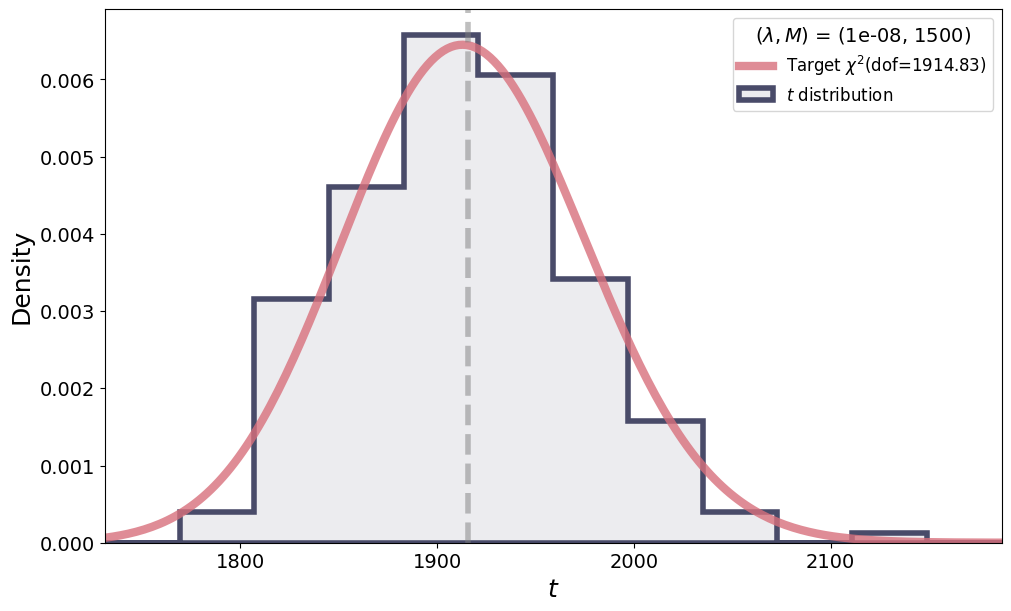

In [100]:
M=1500; l=1e-8
# path="../output/bank_data/N_study/again/2024_2_29_19_17_ref_3000_bkg_1000_sig_0/ttest_time_1e-08_1000.csv"
path1a="../output/bank_data/test_params/2024_2_29_13_36_ref_3000_bkg_1000_sig_0/ttest_time_1e-08_1500.csv"
# path1a="../output/bank_data/test_params/2024_3_1_14_52_ref_3000_bkg_1000_sig_0/ttest_time_1e-08_1500.csv"
from_path_to_plot(path1a,M,l, bin=38)

In [101]:
path_sig2a = "../output/bank_data/N_study/again/signal/2024_3_1_15_51_ref_3000_bkg_1000_sig_20/ttest_time_1e-08_1500.csv"
path_to_Z(path1a, path_sig1a)


KS - p value:	 0.9146
p_value obs:	 1.0
Z = -12.22628 (+0.01/-0.01)



### N(0)=1200

number of toys: 150
ks pvalue: 0.988


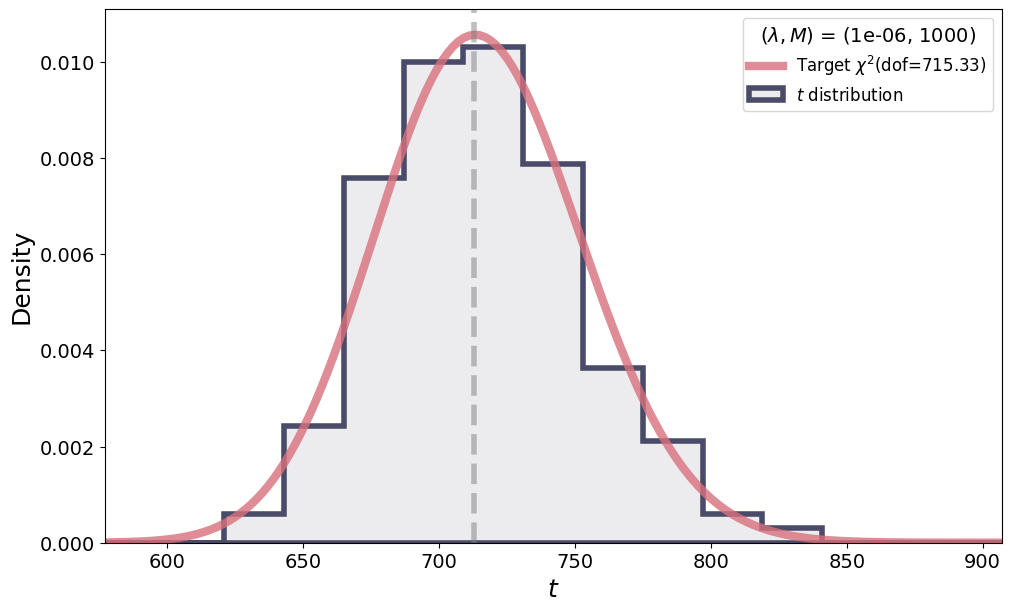

In [102]:
M=1000; l=1e-6
path1b="../output/bank_data/N_study/again/2024_2_29_20_9_ref_3000_bkg_1200_sig_0/ttest_time_1e-06_1000.csv"
from_path_to_plot(path1b,M,l, bin=22)

In [103]:
path_sig1b = "../output/bank_data/N_study/again/signal/2024_3_1_16_22_ref_3000_bkg_1200_sig_24/ttest_time_1e-06_1000.csv"
path_to_Z(path1b, path_sig1b)


KS - p value:	 0.9884
p_value obs:	 0.115
Z = 1.19995 (+0.01/-0.01)



M=1000, l=1e-7

number of toys: 150
ks pvalue: 0.975


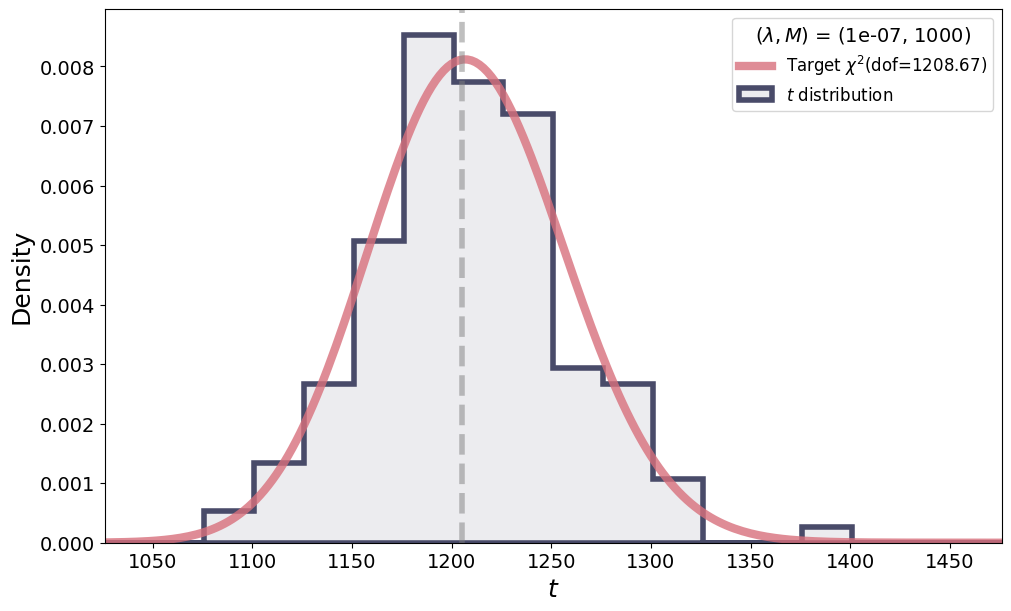

In [104]:
M=1000; l=1e-7
path1c="../output/bank_data/N_study/again/2024_2_29_20_9_ref_3000_bkg_1200_sig_0/ttest_time_1e-07_1000.csv"
from_path_to_plot(path1c,M,l,bin=25)

In [105]:
path_sig1c = "../output/bank_data/N_study/again/signal/2024_3_1_16_24_ref_3000_bkg_1200_sig_24/ttest_time_1e-07_1000.csv"
path_to_Z(path1c, path_sig1c)


KS - p value:	 0.9748
p_value obs:	 0.178
Z = 0.922 (+0.01/-0.01)



M=1500; l=1e-8

number of toys: 150
ks pvalue: 0.99


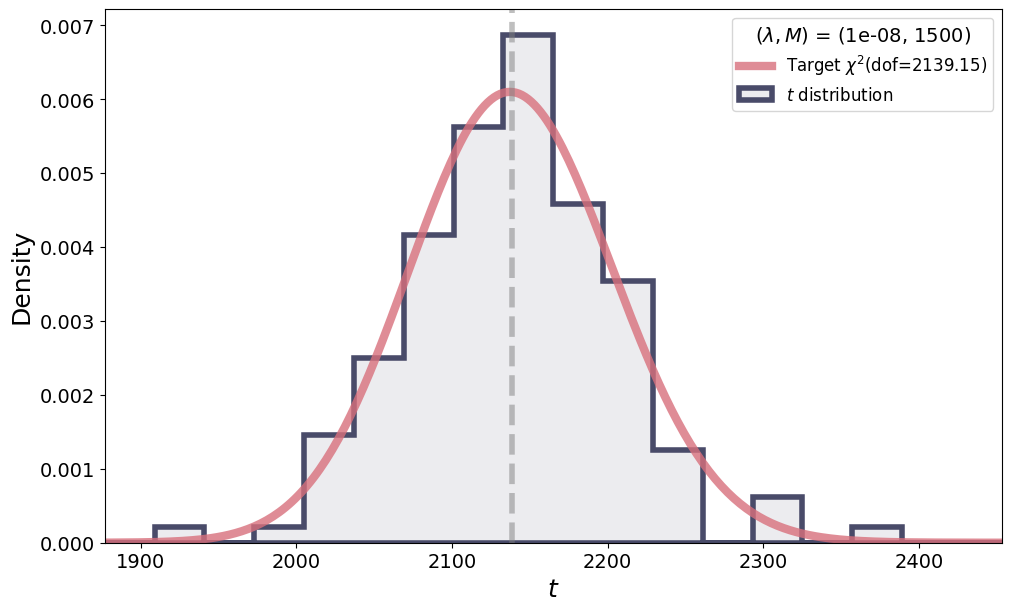

In [106]:
M=1500; l=1e-8
path1d="../output/bank_data/N_study/again/2024_2_29_20_9_ref_3000_bkg_1200_sig_0/ttest_time_1e-08_1500.csv"
from_path_to_plot(path1d,M,l, bin=32)

In [107]:
path_sig1d = "../output/bank_data/N_study/again/signal/2024_3_1_16_29_ref_3000_bkg_1200_sig_24/ttest_time_1e-08_1500.csv"
path_to_Z(path1d, path_sig1d)


KS - p value:	 0.9902
p_value obs:	 0.28
Z = 0.58308 (+0.01/-0.01)



## $N_0=5000$

### N(0)=1000

M=1000; l=1e-8

number of toys: 150
ks pvalue: 0.939


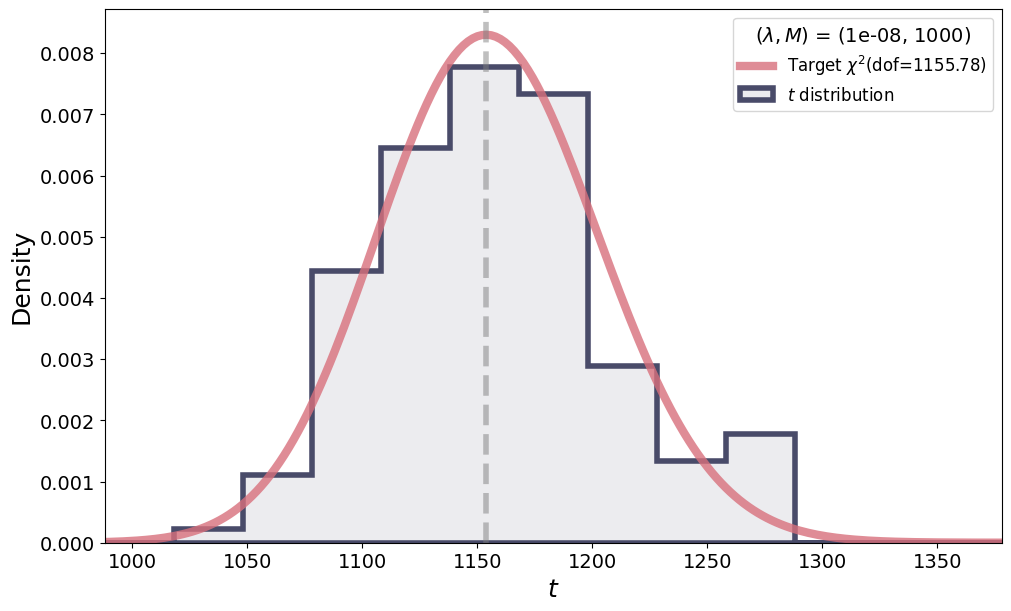

In [108]:
M=1000; l=1e-8
path_ref2 = "../output/bank_data/test_params/2024_2_29_14_34_ref_5000_bkg_1000_sig_0/ttest_time_1e-08_1000.csv"
from_path_to_plot(path_ref2,M,l, bin=30)

In [117]:
path_sig2 = "../output/bank_data/N_study/again/signal/2024_3_1_17_1_ref_5000_bkg_1000_sig_20/ttest_time_1e-08_1000.csv"
path_to_Z(path_ref2, path_sig2)

KS - p value:	 0.9393
p_value obs:	 0.188
Z = 0.88553 (+0.01/-0.01)



M=1500; l=1e-8

number of toys: 150
ks pvalue: 0.931


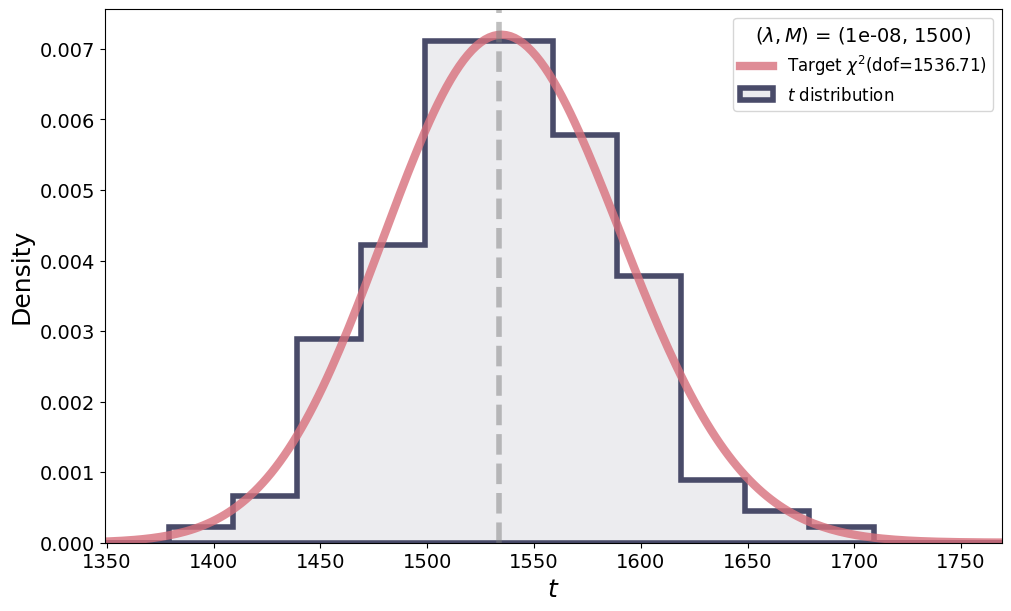

In [110]:
M=1500; l=1e-8
path2a="../output/bank_data/N_study/again/2024_2_29_21_50_ref_5000_bkg_1000_sig_0/ttest_time_1e-08_1500.csv"
from_path_to_plot(path2a,M,l, bin=30)

path_sig2a = "../output/bank_data/N_study/again/signal/2024_3_1_16_29_ref_3000_bkg_1200_sig_24/ttest_time_1e-08_1500.csv"
path_to_Z(path2a, path_sig2a)


M=500; l=1e-7


number of toys: 150
ks pvalue: 0.936


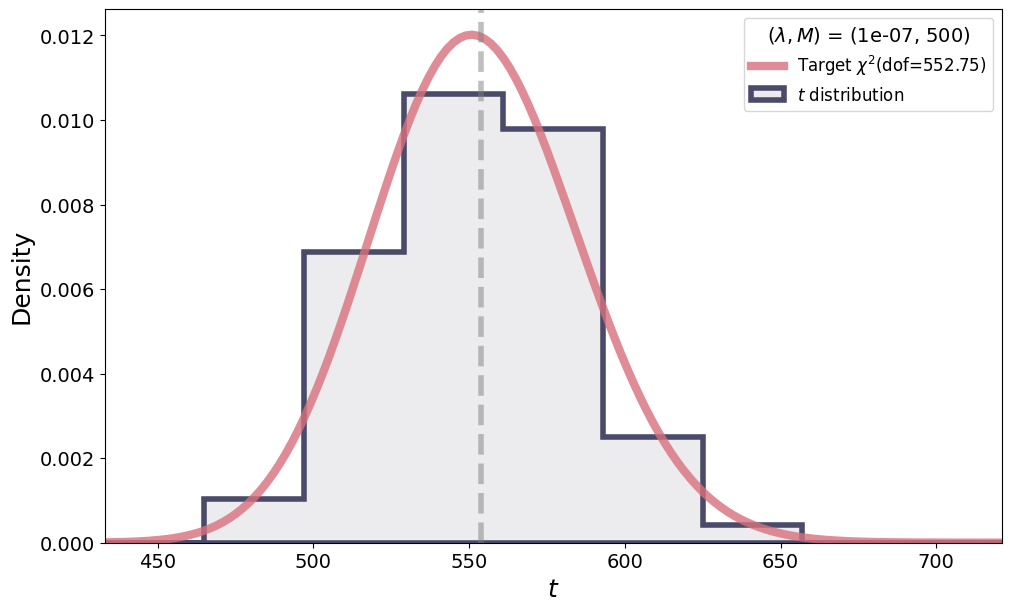

In [111]:
M=500; l=1e-7
path2b="../output/bank_data/N_study/again/2024_2_29_21_50_ref_5000_bkg_1000_sig_0/ttest_time_1e-07_500.csv"
from_path_to_plot(path2b,M,l, bin=32)

### N(0)=1200

M=1500; l=1e-6


number of toys: 150
ks pvalue: 0.987


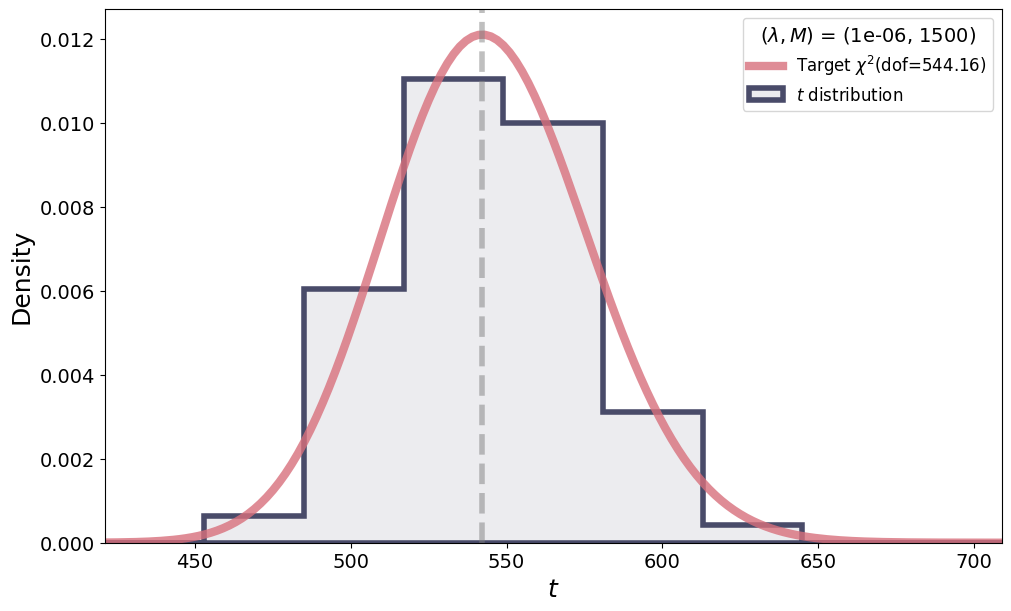

In [112]:
M=1500; l=1e-6
path2c="../output/bank_data/N_study/again/2024_2_29_22_42_ref_5000_bkg_1200_sig_0/ttest_time_1e-06_1000.csv"
from_path_to_plot(path2c,M,l, bin=32)

## $N_0=8000$

### N(0)=1000

M=500; l=1e-7


number of toys: 150
ks pvalue: 0.997


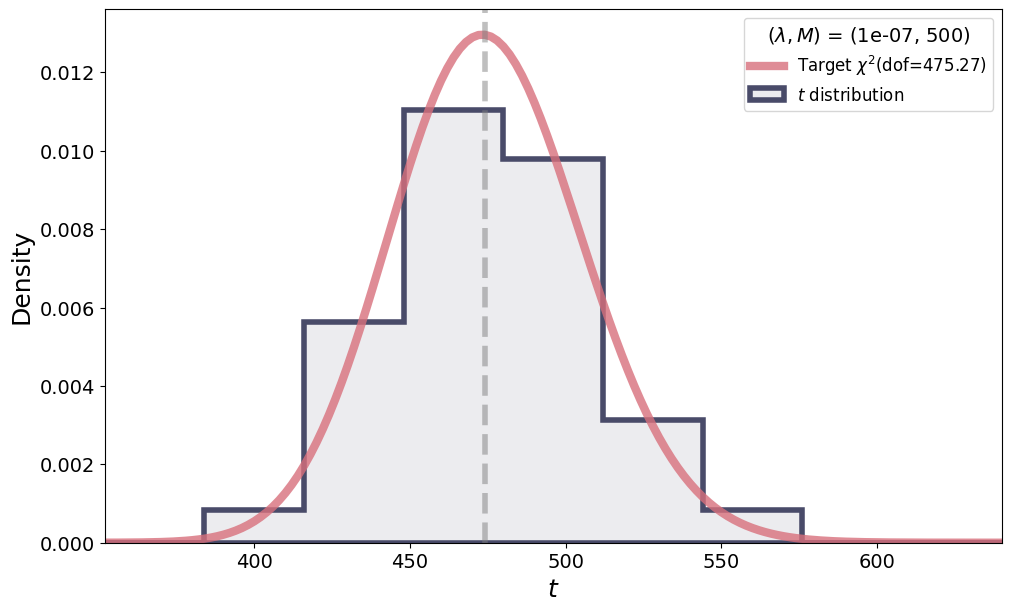

In [113]:
M=500; l=1e-7
path3a="../output/bank_data/N_study/again/2024_3_1_0_23_ref_8000_bkg_1000_sig_0/ttest_time_1e-07_500.csv"
from_path_to_plot(path3a,M,l, bin=32)

N(0)=1200

In [114]:
# M=500; l=1e-7
# path3b="../output/bank_data/N_study/again/2024_3_1_1_14_ref_8000_bkg_1200_sig_0/ttest_time_1e-07_500.csv"
# from_path_to_plot(path3b,M,l, bin=32)

## SIGNAL

In [115]:
def extract_Nsig_SO(file:str):
    matches = re.search(r'_sig_(\d+)_SOn', file)
    return int(matches.group(1))